In [1]:
# Imports and notebook statements
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%load_ext line_profiler

import torch
from torch.nn.functional import conv2d, relu_, unfold, fold
localConv=torch.nn.backends.thnn.backend.SpatialConvolutionLocal
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

import numpy as np
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import seaborn as sns
from sklearn.linear_model import LinearRegression

from utils import *

import warnings
warnings.filterwarnings('ignore')

In [2]:
def localConvolution(activity, weights, kernel):
    outputSize = (activity.shape[-2], activity.shape[-1])
    padding = tuple((k//2 for k in kernel))
    stride = (1, 1)
    unfoldedActivity = unfold(activity, kernel, 1, padding, stride)
    results = (weights*unfoldedActivity).sum(dim = 1)
    return (results.view(1, 1, outputSize[0], outputSize[1]))

In [3]:
# STDP kernel time constant in seconds.  Used for the default kernel.
STDP_TIME_CONSTANT = 0.012

def w_0(x):
    """
    @param x (numpy array)
    A distance
    """
    a = 1.00
    lambda_net = 13.0
    beta = 3.0 / lambda_net ** 2
    gamma = 1.05 * beta

    return a * np.exp(-gamma * x) - np.exp(-beta * x)

def ew(x):
    """
    @param x (numpy array)
    A distance
    """
    lambda_net = 13.0
    beta = 3.15 / lambda_net ** 2

    return np.exp(-beta * x)

def w_1(x):
    """
    @param x (numpy array)
    A distance
    """
    lambda_net = 13.0
    beta = 3.15 / lambda_net ** 2

    return - np.exp(-beta * x)   

# Random walk builder
def buildTrajectory(length, stepSize, width=1., directionStability=0.95, wrap=False, circular=False):
    trajectory = np.zeros((int(length), 2))
    turns = np.zeros((int(length)))
    if circular:
        r = np.sqrt(np.random.rand())*width
        angle = np.random.rand()*2.*np.pi
        x = np.cos(angle)*r
        y = np.sin(angle)*r
    else:
        x = np.random.rand()*width
        y = np.random.rand()*width
    direction = np.random.rand() * 2 * np.pi
    twopi = 2*np.pi
    for i in range(int(length)):
        oldDir = direction
        recenter = 0
        patience = 0
        while True:
            # This is a random value between (-180, +180) scaled by directionStability
            dirChange = ((recenter + (np.random.rand() * twopi) - np.pi) *
                       (1.0 - directionStability + patience))
            direction = (direction + dirChange) % twopi
            rotation = np.asarray([np.cos(direction), np.sin(direction)])
            movement = stepSize*rotation
            if circular:
                position = (movement[0] + x)**2 + (movement[1] + y)**2
                print(np.sqrt(position), width)
                inBounds = np.sqrt(position) < width
            else:
                inBounds = 0 < (movement[0] + x) < width and 0 < (movement[1] + y) < width
            if inBounds or wrap:
                x += movement[0]
                y += movement[1]
                trajectory[i] = (x, y)
                turns[i] = np.abs(oldDir - direction)
                oldDir = direction
                break
            else:
                patience += .5
                recenter = oldDir
                

    return(trajectory, turns)

In [4]:
plt.rcParams['figure.figsize'] = [5, 5]
speed = .2
traj, turns = buildTrajectory(30/(0.01),
                              speed*0.01,
                              circular=False,
                              directionStability=.92)#1-(0.05*np.sqrt(speed)))
plt.figure()
plt.plot(traj[:, 0], traj[:, 1])
plt.show()

<IPython.core.display.Javascript object>

In [27]:
class GCN2D(object):
    
    def __init__(self,
                 numX,
                 numY,
                 inhibitionWindow,
                 inhibitionRadius,
                 inhibitionStrength,
                 excitationWindow,
                 excitationCenterBlock=0,
                 smoothingWindow=1,
                 boostEffect=10,
                 boostDecay=3.,
                 dt=0.001,
                 numPlaces=200,
                 placeMax=5,
                 placeMean=1.5,
                 circularPlaces=False,
                 globalTonic=20,
                 decayConstant=0.03,
                 envelopeWidth=0.25,
                 envelopeFactor=10,
                 stdpWindow=10,
                 sigmaLoc=0.05,
                 learningRate=0.015,
                 negativeLearnFactorP=.9,
                 negativeLearnFactorE=.9,
                 initialWeightFactor=.2,
                 initialExcitatoryFactor=.2,
                 weightDecay=60,
                 boostGradientX=1,
                 wideningFactor=0,
                 hardwireE=False,
                 hardwireEStrength=1.,
                 hardwireERange=1.,
                 hardwireEOffset=1.,
                 hardwireEGradientX=1.,
                 learningRateE=0.01,
                 envSize=1.,
                ):
        self.activity = torch.zeros([1., 1., numX, numY], device=device, dtype=torch.float)
        self.filter = torch.zeros([1, 1, 1+2*inhibitionWindow, 1+2*inhibitionWindow], dtype=torch.float,
                                 device=device)
        
        self.smoothingKernel = torch.ones([1, 1, 1+2*smoothingWindow, 1+2*smoothingWindow], dtype=torch.float,
                         device=device)
        size = (1+2*smoothingWindow)**2
        self.smoothingKernel /= size
        self.smoothingWindow = smoothingWindow
            
        self.numX = numX
        self.numY = numY
        self.numPlaces=numPlaces
        self.placeMax = placeMax
        self.placeMean = placeMean
        self.envSize=envSize
        
        for i in range(1+2*inhibitionWindow):
            for j in range(1+2*inhibitionWindow):
                xComp = np.abs(i - (inhibitionWindow))
                yComp = np.abs(j - (inhibitionWindow))
                dist = np.asarray((xComp, yComp))
                dist = dist[0] ** 2 + dist[1] ** 2
                
                dist = max(dist - wideningFactor, 0)
                if dist <= 0:
                    weight = 0.
                else:
                    weight = w_0(dist/inhibitionRadius)*inhibitionStrength
                
                self.filter[0, 0, i, j] = weight
                
        self.activationHistory = torch.zeros([1, 1, numX, numY], device=device, dtype=torch.float)
        self.instantaneous = torch.zeros([1, 1, numX, numY], device=device, dtype=torch.float)
        
        self.directions = {"e": torch.tensor([0, 1], device=device, dtype=torch.float),
                           "w": torch.tensor([0, -1], device=device, dtype=torch.float),
                           "s": torch.tensor([1, 0], device=device, dtype=torch.float),
                           "n": torch.tensor([-1, 0], device=device, dtype=torch.float),
                          }
        
        self.excitatoryWeights = dict((k, torch.randn(1, (2*excitationWindow+1)*(2*excitationWindow+1),
                                                      self.numX*self.numY,
                        device=device, dtype=torch.float)*initialExcitatoryFactor)
                                      for k in self.directions.keys())
        
        self.kernel = ((2*excitationWindow+1), (2*excitationWindow+1))
        self.bias=torch.zeros((1,self.numX,self.numY), device=device, dtype=torch.float) # outC x outH x outW

        self.localConv=localConv.apply
        
        self.boostEffect = torch.tensor(np.repeat(
            np.linspace(1, boostGradientX, self.numX)[:, np.newaxis], self.numY, axis=-1)*boostEffect,
                                       device=device, dtype=torch.float)
        self.alpha = boostDecay
        self.dt = dt
        self.globalTonic = torch.tensor([globalTonic], device=device, dtype=torch.float)
        self.decay = decayConstant
        self.inhibitionWindow = inhibitionWindow
        self.excitationWindow = excitationWindow
        self.envelopeWidth = envelopeWidth
        self.envelopeFactor = envelopeFactor
        self.sigmaLoc = sigmaLoc
        self.learningRate = learningRate
        self.learningRateE = learningRateE
        self.negativeLearnFactorP = negativeLearnFactorP
        self.negativeLearnFactorE = negativeLearnFactorE
        self.weightDecay = weightDecay
        
        self.zero = torch.zeros([1], device=device, dtype=torch.float)
        
        if circularPlaces:
            angles = np.random.rand(numPlaces)*2*np.pi
            radii = np.sqrt(np.random.rand(numPlaces))*self.envSize
            xComp = np.cos(angles)
            yComp = np.sin(angles)
            places = np.stack([xComp*radii, yComp*radii], axis=-1)
            self.places = torch.tensor(places, device=device, dtype=torch.float)
        else:
            self.places = torch.tensor(np.random.rand(numPlaces, 2)*self.envSize, device=device, dtype=torch.float)
        
        self.placeWeights = torch.tensor(np.random.rand(numX, numY, numPlaces)*initialWeightFactor,
                                         device=device, dtype=torch.float)
        
        self.placeActivity = torch.zeros([numPlaces,], device=device, dtype=torch.float)
        self.placeHistory = torch.zeros([numPlaces,], device=device, dtype=torch.float)
        
        self.envelope = torch.tensor(self.computeEnvelope(), device=device, dtype=torch.float)
        
        self.stdpWindow = stdpWindow
        
        # Hardwire the excitatory weights
        
        self.excitationMask = torch.zeros(1, (2*excitationWindow+1)*(2*excitationWindow+1), 1,
                        device=device, dtype=torch.float)

        for i in range(1+2*excitationWindow):
            for j in range(1+2*excitationWindow):
                xComp = np.abs(i - (excitationWindow))
                yComp = np.abs(j - (excitationWindow))
                dist = np.asarray((xComp, yComp))
                dist = dist[0] ** 2 + dist[1] ** 2

                if np.sqrt(dist) > excitationCenterBlock:
                    self.excitationMask[:, i*(1+2*excitationWindow) + j, :] = 1.

        if hardwireE:
            for k, direction in self.directions.items():
                for i in range(1+2*excitationWindow):
                    for j in range(1+2*excitationWindow):
                        
                        xComp = np.abs(i + hardwireEOffset*direction[0] - (excitationWindow))
                        yComp = np.abs(j + hardwireEOffset*direction[1] - (excitationWindow))
                        dist = np.asarray((xComp, yComp))
                        dist = dist[0] ** 2 + dist[1] ** 2

                        weight = ew(dist/hardwireERange)*hardwireEStrength

                        self.excitatoryWeights[k][:, i*(1+2*excitationWindow) + j, :] = weight
                        
                for i, f in enumerate(np.linspace(1., hardwireEGradientX, self.numX)):
                    self.excitatoryWeights[k][:, :, i*self.numY:(i+1)*self.numY] *= f
            

    def computeEnvelope(self):
        """
        Compute an envelope for use in suppressing border cells.
        :return: A numpy array that can be elementwise-multiplied with activations
                 for the given cell population to apply the envelope.
        """
        envelope = np.zeros((self.numX, self.numY))
        for i, ip in enumerate(np.linspace(-1, 1, self.numX)):
            for j, jp in enumerate( np.linspace(-1, 1, self.numY)):
                dist = np.sqrt(ip**2 + jp**2)
                if dist < 1 - self.envelopeWidth:
                    envelope[i, j] = 1.
                else:
                    envelope[i, j] = np.exp(-1.*self.envelopeFactor *
                          ((dist - 1 + self.envelopeWidth)/self.envelopeWidth)**2)
        return envelope
                
#         envelopeX = [1 if self.numX/2. - np.abs(p) > self.envelopeWidth else
#                           np.exp(-1.*self.envelopeFactor *
#                           ((-self.numX/2. + np.abs(p) + self.envelopeWidth)/self.envelopeWidth)**2)
#                           for p in np.arange(self.numX) - self.numX/2.]

#         envelopeY = [1 if self.numY/2. - np.abs(p) > self.envelopeWidth else
#                           np.exp(-1.*self.envelopeFactor *
#                           ((-self.numY/2. + np.abs(p) + self.envelopeWidth)/self.envelopeWidth)**2)
#                           for p in np.arange(self.numY) - self.numY/2.]

#         return np.outer(envelopeX, envelopeY)

    def randomLesions(self, numLesions, lesionRadius, lesionInnerCutoff):
        lesions = []
        for i in range(numLesions):
            x = int(np.random.rand()*self.numX)
            y = int(np.random.rand()*self.numY)
            lesions.append((x, y))
            
        radii = [lesionRadius] * numLesions
        cutoffs = [lesionInnerCutoff] * numLesions
        
        self.addLesions(lesions, radii, cutoffs)
    
    
    def addLesions(self, lesionCenters, lesionRadii, lesionInnerCutoffs):
        for center, radius, cutoff in zip(lesionCenters, lesionRadii, lesionInnerCutoffs):
            for x in range(self.numX):
                for y in range(self.numY):
                    distance = np.sqrt((x - center[0])**2 + (y - center[1])**2)
                    if distance < cutoff:
                        self.envelope[x, y] = 0.
                    elif distance < radius:
                        value = (distance - cutoff)/(radius - cutoff)
                        self.envelope[x, y] = min(value, self.envelope[x, y])

                        
    def step(self, vel, speed=1, turn=1., place=True, normalize=False):
        with torch.no_grad():
            if place:
                self.instantaneous = torch.matmul(self.placeWeights, self.placeActivity).view(1, 1, self.numX, self.numY)
            else:
                self.instantaneous.fill_(0.)
            self.instantaneous += conv2d(self.activity, self.filter, padding=self.inhibitionWindow)
            for k, weights in self.excitatoryWeights.items():
                direction = torch.dot(self.directions[k], vel)
                excitatoryInput = torch.max(localConvolution(self.activity,
                                                                 weights,
                                                                 self.kernel)*direction,
                                                self.zero)
                self.instantaneous += excitatoryInput
            self.instantaneous += self.globalTonic
            self.instantaneous *= self.envelope
            self.instantaneous -= self.activationHistory * self.boostEffect
            self.instantaneous *= min(speed, 1)
            relu_(self.instantaneous)
            self.activity += (self.instantaneous - self.activity/self.decay)*self.dt
            
            if normalize:
                target = 0.00000613232*self.numX*self.numY
                self.activity = self.activity*.9 + self.activity*.1*target/torch.sum(self.activity**2)
            
                print("Post:", torch.sum(self.activity))
            
            self.activationHistory = (1 - (1 - self.alpha)/turn)*self.activity +\
                                     ((1. - self.alpha)/turn)*self.activationHistory

        
    def simulate(self, time, vel = (0,0), logFreq = 10, startFrom = 0):
        self.activity = torch.tensor(np.random.rand(1, 1, self.numX, self.numY)*0.1, device=device,
                                                 dtype=torch.float)
        
        vel = torch.tensor(vel, device = device, dtype=torch.float)
        self.activationHistory.fill_(self.globalTonic[0])
        
        numSteps = int(time/self.dt)
        numLogs = int(((time - startFrom)/self.dt)/logFreq)
        output = torch.zeros([numLogs, self.numX, self.numY], device=device, dtype=torch.float)
        
        s = 0
        for t in range(numSteps):
            self.step(vel, place=False)
            if t % logFreq == 0 and t*self.dt >= startFrom:
                print("At {}".format(t*self.dt))
                output[s].copy_(self.activity.view(self.numX, self.numY))
                s += 1
                
        return output.cpu().numpy()
    
    
    def decayWeights(self):
        """
        Only decay place weights
        """
        self.placeWeights -= self.dt*self.placeWeights/self.weightDecay
    
    
    def learn(self, time, plotting=True, plotInterval=100, runLength=10, oneD=False, learnStart=0.,
              stab=0.97, wrap=False, circular=False, speed=0.5, localNormalization=True):
        if plotting:
                fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1)
                ax1.scatter(self.places[:, 1].cpu().numpy(),
                    self.places[:, 0].cpu().numpy(),
                    c = self.placeActivity.cpu().numpy(),
                    cmap = plt.get_cmap("coolwarm"))
                im1 = ax2.matshow(self.activity.view((self.numX, self.numY)).cpu().numpy())
                cb1 = fig.colorbar(im1, ax=ax2)
                
                im2 = ax3.matshow(self.activity.view((self.numX, self.numY)).cpu().numpy())
                cb2 = fig.colorbar(im2, ax=ax3)
                
                im3 = ax4.scatter(self.places[:, 1].cpu().numpy(),
                            self.places[:, 0].cpu().numpy(),
                            c = self.placeWeights[self.numX//2, self.numY//2, :].cpu().numpy(),
                            cmap = plt.get_cmap("coolwarm"))
                cb3 = fig.colorbar(im3, ax=ax4)
                plt.show()
                
        self.activityBuffer = torch.zeros([self.stdpWindow, self.numX*self.numY],
                                          device=device, dtype=torch.float)
        self.placeBuffer = torch.zeros([self.stdpWindow, self.numPlaces],
                                       device=device, dtype=torch.float)
        self.velBuffer = torch.zeros([self.stdpWindow, 2], device=device, dtype=torch.float)
        
        self.stdpValues = torch.tensor(np.exp(-self.dt*np.arange(0, self.stdpWindow)/STDP_TIME_CONSTANT),
                                       device=device, dtype=torch.float)*self.dt
        self.bufferIndex = 0
        
        times = np.arange(0, time, self.dt)
        
        self.activity = torch.tensor(np.random.rand(1, 1, self.numX, self.numY)*0.1, device=device,
                                                 dtype=torch.float)
        self.activationHistory.fill_(0)
        self.activationHistory *= self.envelope
        
        trajectory, turns = buildTrajectory(len(times),
                                            speed*self.dt,
                                            width=self.envSize,
                                            wrap=wrap,
                                            directionStability=stab,
                                            circular=circular)
        
        if oneD:
              trajectory[:, 1] = 0.
        velocity = np.diff(trajectory, axis=0)/self.dt
        
        if wrap:
            trajectory = np.mod(trajectory, 1)
        trajectory = torch.tensor(trajectory, device=device, dtype=torch.float)
        velocity = torch.tensor(velocity, device=device, dtype=torch.float)
        turns = torch.tensor(turns, device=device, dtype=torch.float)
        speed = torch.norm(velocity, 2, dim=-1)
        distances = torch.zeros((self.numPlaces, 2), device=device, dtype=torch.float)
        
        turnScaling = torch.max(turns/torch.mean(turns), self.zero + 1.)        
        speedScaling = torch.min(speed/torch.mean(speed), self.zero + 1.)
        
        for i, t in enumerate(times[:-1]):
            pos = trajectory[i, :]
            turn = turnScaling[i]
            s = speedScaling[i]
            vel = velocity[i]
            if wrap:
                distances[:,0] = torch.min(torch.abs(self.places[:,0] - pos[0]), 1 - torch.abs(self.places[:,0] - pos[0]))
                distances[:,1] = torch.min(torch.abs(self.places[:,1] - pos[1]), 1 - torch.abs(self.places[:,1] - pos[1]))
            else:
                distances[:,0] = torch.abs(self.places[:,0] - pos[0])
                distances[:,1] = torch.abs(self.places[:,1] - pos[1])
      
            if oneD:
                distances[:,1] = 0.
            torch.exp(-1.*torch.norm(distances, 2, dim=-1)/(2*(self.sigmaLoc)), out=self.placeActivity)
            self.placeActivity *= s
            self.placeHistory = self.alpha*self.placeActivity +\
                                     (1. - self.alpha)*self.placeHistory
            self.step(vel, speed=s, turn=turn)
            if t > learnStart:
                if self.learningRateE > 0:
                    self.stdpUpdate(i, vel, places=False)
                self.bcmPlaceUpdate()
            self.placeWeights = torch.max(self.placeWeights, self.zero)
            self.placeWeights = torch.min(self.placeWeights, self.zero + self.placeMax)
#           self.placeWeights *= self.placeMean/torch.mean(self.placeWeights, 0, keepdim=True)
            inMean = torch.mean(self.placeWeights.view(self.numX*self.numY, self.numPlaces), -1)
            weightedWeights = self.envelope.view(self.numX, self.numY, 1)*self.placeWeights/torch.mean(self.envelope)
            outMean = torch.mean(weightedWeights.view(self.numX*self.numY, self.numPlaces), 0)
            productMean = torch.ger(inMean, outMean).view(self.numX, self.numY, self.numPlaces)
            self.placeWeights *= self.placeMean/productMean
            
            for k, weights in self.excitatoryWeights.items():
                weights = torch.max(weights, self.zero)
                weights = torch.min(weights, self.zero + .5)
                self.excitatoryWeights[k] = self.excitationMask*.25*weights/torch.mean(weights, -2, keepdim=True)
                    
            if localNormalization:
                allWeights = torch.stack([weights for k, weights in self.excitatoryWeights.items()], dim = -1)
                average = torch.mean(allWeights, dim=-1, keepdim=False)
                for k, weights in self.excitatoryWeights.items():
                    self.excitatoryWeights[k] = (weights + (0.25 - average))*self.excitationMask
                    

            #self.decayWeights()
            if i % plotInterval == 0:
                if plotting:
                    ax1.scatter(self.places[:, 1].cpu().numpy(),
                        self.places[:, 0].cpu().numpy(),
                        c = self.placeActivity.cpu().numpy(),
                        cmap = plt.get_cmap("coolwarm"))
                    mat = self.activity.view((self.numX, self.numY)).cpu().numpy()
                    ax2.matshow(mat)
                    cb1.set_clim(vmin=np.min(mat),vmax=np.max(mat))
                    cb1.draw_all()

                    mat = self.placeWeights[self.numX//2, self.numY//2, :].cpu().numpy()
                    im = ax4.scatter(self.places[:, 1].cpu().numpy(),
                                self.places[:, 0].cpu().numpy(),
                                c = mat,
                                cmap = plt.get_cmap("coolwarm"))
                    cb3.set_clim(vmin=np.min(mat),vmax=np.max(mat))
                    cb3.draw_all()

                    
#                     self.instantaneous.fill_(0.)
#                     for k, weights in self.excitatoryWeights.items():
#                         weights = self.excitatoryWeights[k]
#                         direction = torch.dot(self.directions[k], vel)
#                         excitatoryInput = localConvolution(self.activity, weights, self.kernel)*direction
#                         self.instantaneous += excitatoryInput
                                
                    mat = self.activationHistory.view((self.numX, self.numY)).cpu().numpy()
                    cb2.set_clim(vmin=np.min(mat),vmax=np.max(mat))
                    cb2.draw_all()

                    ax3.matshow(mat)
                    ax1.set_title("Time {}, position ({}, {})".format(t, pos[0], pos[1]))
                    fig.canvas.draw()
                
                
    def bcmPlaceUpdate(self):
        update = self.dt*self.learningRate*(torch.ger(self.activity.view(self.numX*self.numY),
                                                    self.placeActivity) -\
                                               torch.ger(self.activationHistory.view(self.numX*self.numY),
                                                    self.placeHistory)).view(1, 1, self.numX, self.numY, self.numPlaces)
        update = torch.transpose(update, 0, -1)
        update = torch.squeeze(update, dim=-1)
        update = conv2d(update, self.smoothingKernel, padding=self.smoothingWindow)
        update = torch.unsqueeze(update, -1)
        update /= torch.mean(self.activity)
        self.placeWeights += torch.transpose(update, 0, -1).view(self.numX, self.numY, self.numPlaces)
                                      
                
    def stdpUpdate(self,
                   time,
                   vel,
                   clearBuffer=False,
                   covarianceCorrection=True,
                   places=False):
        if self.bufferIndex < self.activityBuffer.shape[0]:
            self.activityBuffer[self.bufferIndex].copy_(self.instantaneous.view(self.numX*self.numY,))
            if places:
                self.placeBuffer[self.bufferIndex].copy_(self.placeActivity)
            self.velBuffer[self.bufferIndex].copy_(vel)
            self.bufferIndex += 1
            
        else:
            for t in range(self.stdpWindow):
                i = (self.bufferIndex - t) % self.stdpWindow
                if covarianceCorrection:
                    correction1 = torch.mean(self.activity)
                    correction2 = torch.mean(self.activityBuffer[i])
                else:
                    correction1 = 0
                    correction2 = 0
                if places:
                    self.placeWeights += torch.ger(self.activity.view(self.numX*self.numY) - correction1, self.placeBuffer[i]* \
                                            self.stdpValues[t]).view(self.numX, self.numY, self.numPlaces)*self.learningRate
                    self.placeWeights -= (torch.ger(self.activityBuffer[i] - correction2, self.placeActivity) *\
                                            self.stdpValues[t]).view(self.numX, self.numY, self.numPlaces) *\
                                            self.negativeLearnFactorP*self.learningRate
                
                for k, weights in self.excitatoryWeights.items():
                    dForward = torch.max(torch.dot(self.directions[k],
                                                   self.velBuffer[i])/torch.norm(self.velBuffer[i]), self.zero)
                    dBackward = torch.max(torch.dot(self.directions[k],
                                                    vel)/torch.norm(vel), self.zero)
                    
#                     if dForward < 0.4:
#                         dForward = -1.
#                     if dBackward < 0.4:
#                         dBackward = -1.
                    
                    padding = tuple((k//2 for k in self.kernel))
                    stride = (1, 1)
                    unfoldedActivity = unfold(self.instantaneous, self.kernel, 1, padding, stride)
                    weights -= unfoldedActivity*\
                                self.stdpValues[t]*\
                                self.negativeLearnFactorE*\
                                dBackward*\
                                (self.activityBuffer[i].view(self.numX*self.numY)-correction2)*self.learningRateE
                    
                    unfoldedActivity = unfold(self.activityBuffer[i].view(1, 1, self.numX, self.numY), self.kernel, 1, padding, stride)
                    weights += unfoldedActivity*\
                                self.stdpValues[t]*\
                                dForward*\
                                (self.instantaneous.view(self.numX*self.numY)-correction1)*self.learningRateE    
                        
            self.bufferIndex += 1
            self.activityBuffer[self.bufferIndex % self.stdpWindow].copy_(self.activity.view(self.numX*self.numY,))
            self.placeBuffer[self.bufferIndex % self.stdpWindow].copy_(self.placeActivity)
            
        if clearBuffer:
            pass

<IPython.core.display.Javascript object>


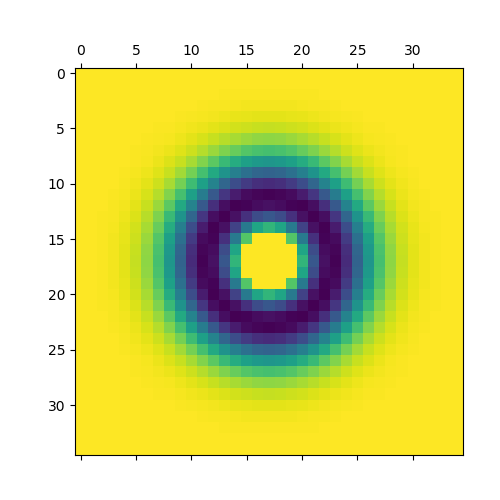

<IPython.core.display.Javascript object>


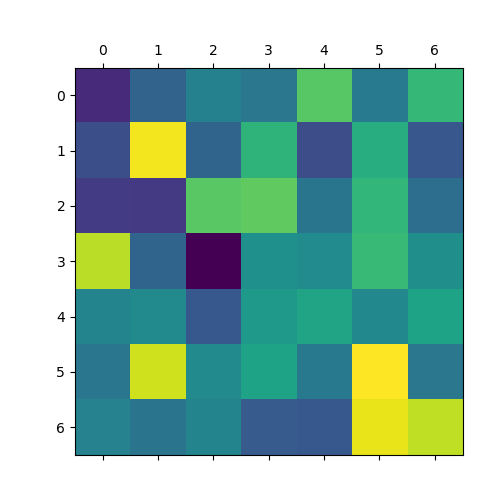

<IPython.core.display.Javascript object>


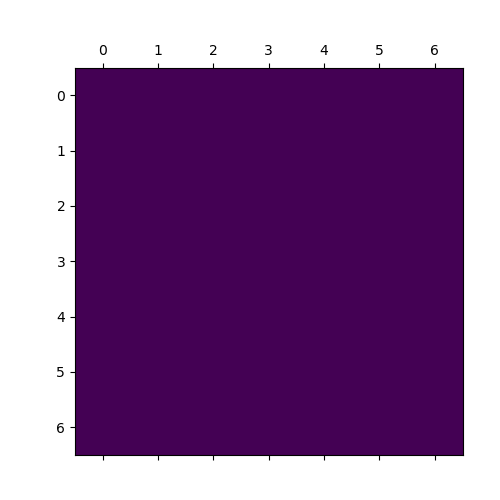

<IPython.core.display.Javascript object>


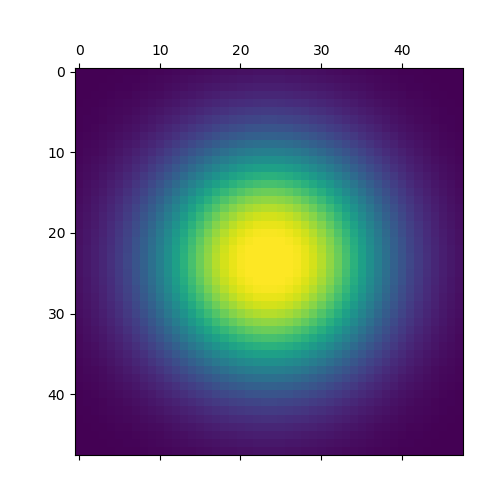

In [30]:
plt.rcParams['figure.figsize'] = [5, 5]

GCN = GCN2D(48,
            48,
            17,
            .5,
            1000.,
            3,
            wideningFactor=5,
            excitationCenterBlock=-1,
            globalTonic=15.,
            stdpWindow=2,
            dt=0.01,
            placeMax=1.,
            placeMean=.25,
            boostEffect=100.,
            boostDecay=.1,
            numPlaces=1000,
            circularPlaces=True,
            learningRate=1.,
            initialWeightFactor=1.2,
            initialExcitatoryFactor=0.05,
            boostGradientX=1,
            weightDecay=500,
            negativeLearnFactorP=.9,
            negativeLearnFactorE=1.2,
            learningRateE=0,
            envelopeWidth=.9,
            envelopeFactor=3.0,
            sigmaLoc=(.15)**2,
            hardwireE=False,
            hardwireEStrength=3.,
            hardwireERange=.05,
            hardwireEOffset=2.,
            hardwireEGradientX=2.,
            envSize=.5,)

#GCN.randomLesions(10, 10, 5)

plt.matshow(GCN.filter[0,0])
plt.show()

# plt.matshow(GCN.excitatoryWeights["n"][:, :, 8].view(25, 25).detach())
# plt.show()


# plt.matshow(GCN.excitatoryWeights["s"][:, :, 8].view(25, 25).detach())
# plt.show()


plt.matshow(GCN.excitatoryWeights["e"][:, :, 8].view(GCN.excitationWindow*2+1, GCN.excitationWindow*2+1).detach())
plt.show()

plt.matshow(GCN.excitationMask[:, :, 0].view(GCN.excitationWindow*2+1, GCN.excitationWindow*2+1).detach())
plt.show()

# plt.matshow(GCN.excitatoryWeights["w"][:, :, -1].view(11, 11).detach())
# plt.show()

plt.matshow(GCN.envelope)
plt.show()


# plt.matshow(GCN.boostEffect)
# plt.show()

# plt.figure()
# plt.scatter(GCN.places[:, 0].cpu().numpy(),
#              GCN.places[:, 1].cpu().numpy())
# plt.show()

In [55]:
plt.rcParams['figure.figsize'] = [5, 15]
lr = 1.#GCN.learningRate
for i in range(1000):
    GCN.learningRate = lr/(i+17)
    print(i, GCN.learningRate)
    GCN.learn(150,
              plotting=False,
              learnStart=1.5,
              stab=0.98,
              speed=.1,
              circular=True,
              localNormalization=False)

0 0.058823529411764705


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


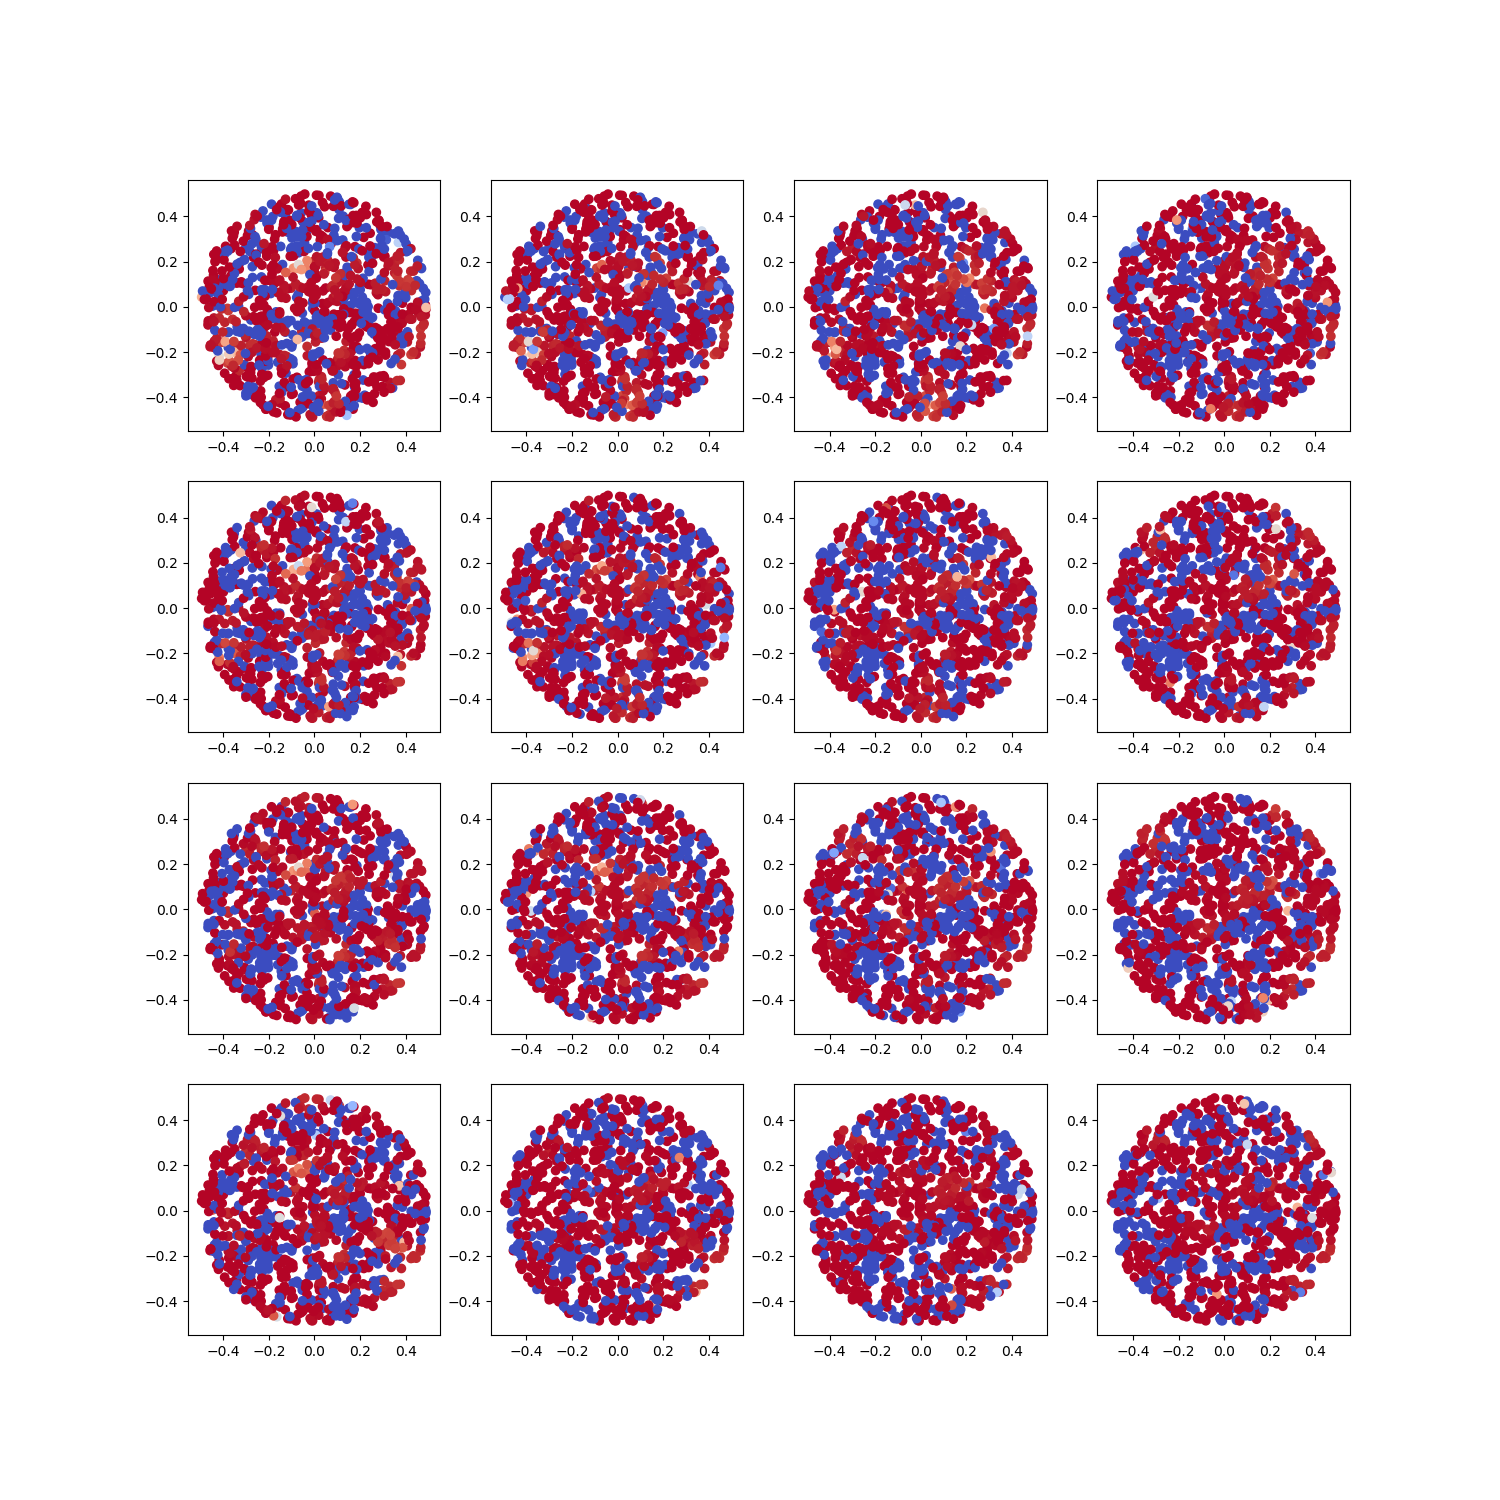

In [54]:
plt.rcParams['figure.figsize'] = [15, 15]
plt.figure()
xstart = 28
xend = 32
ystart = 28
yend = 32
for i in range(xstart, xend):
    for j in range(ystart, yend):
        index = (i - xstart)*(yend - ystart) + (j - ystart) + 1
        plt.subplot((xend - xstart), (yend - ystart), index)
        plt.scatter(GCN.places[:, 0].cpu().numpy(),
                    GCN.places[:, 1].cpu().numpy(),
                    c = GCN.placeWeights[i, j, :].cpu().numpy(),
                    cmap = plt.get_cmap("coolwarm"))
        plt.draw()

<IPython.core.display.Javascript object>


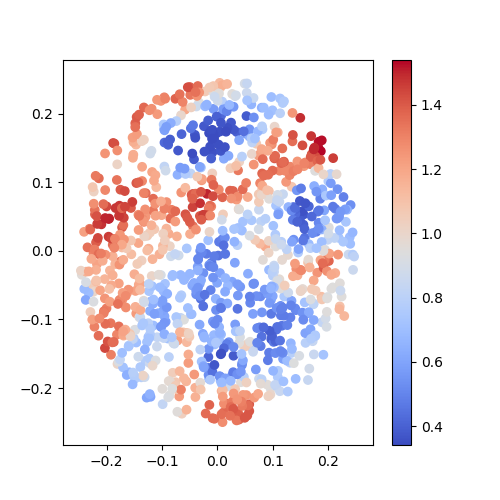

<IPython.core.display.Javascript object>


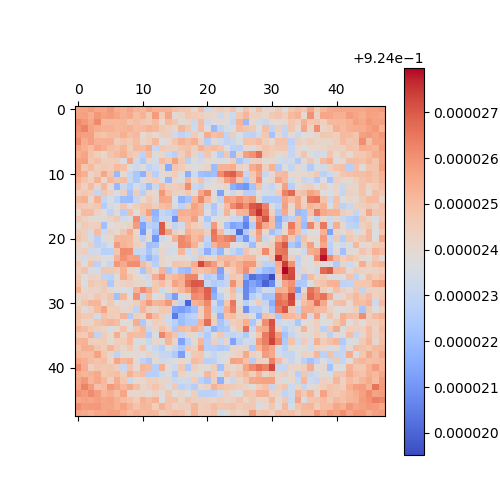

In [21]:
plt.rcParams['figure.figsize'] = [5, 5]
plt.figure()
plt.scatter(GCN.places[:, 0].cpu().numpy(),
            GCN.places[:, 1].cpu().numpy(),
            c = torch.mean(GCN.placeWeights.view(GCN.numX*GCN.numY, GCN.numPlaces), dim=0).cpu().numpy(),
            cmap = plt.get_cmap("coolwarm"))
plt.colorbar()
plt.show()

plt.matshow(torch.mean(GCN.placeWeights, dim=-1).cpu().numpy(),
            cmap = plt.get_cmap("coolwarm"))
plt.colorbar()
plt.show()

In [61]:
GCN.placeMax /= 2.
GCN.placeMean /= 2.

<IPython.core.display.Javascript object>


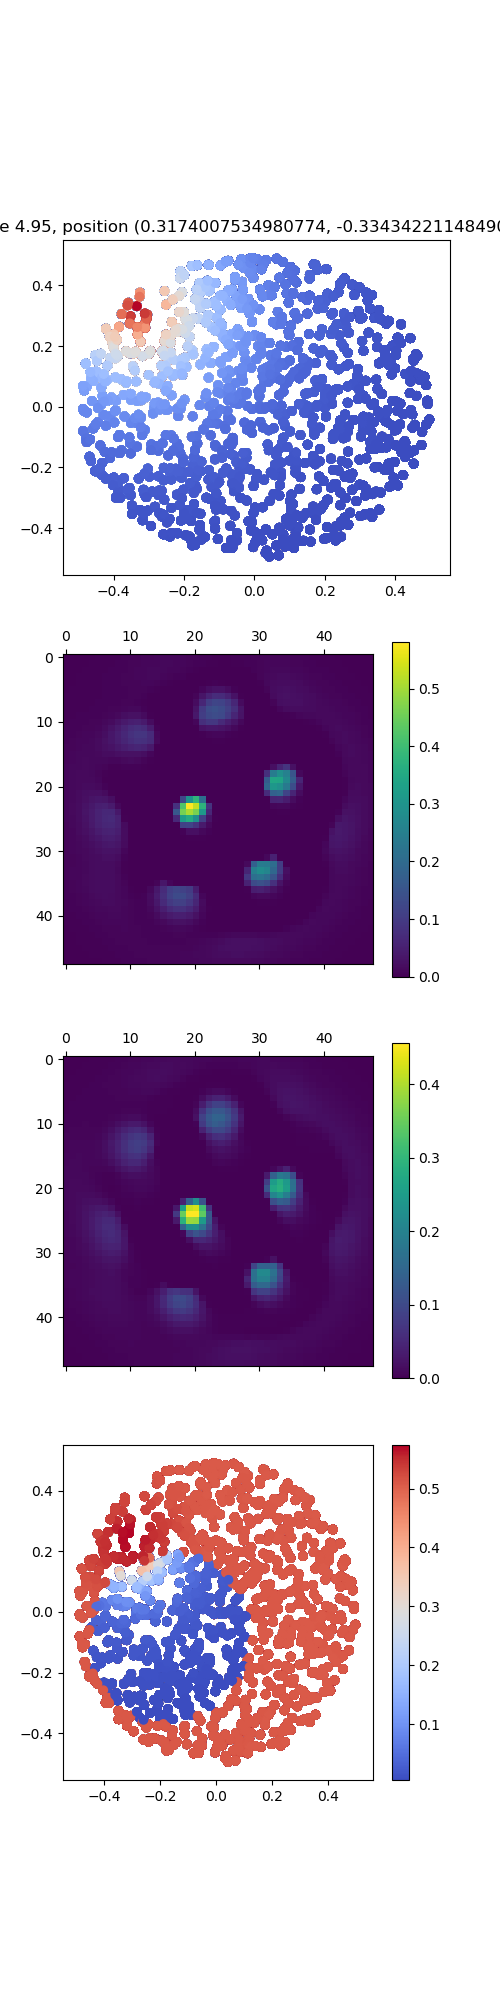

In [64]:
GCN.learningRate = 5.
plt.rcParams['figure.figsize'] = [5, 20]
GCN.learn(5.,
          plotting=True,
          plotInterval=5,
          oneD=False,
          learnStart=0.,
          stab=.99,
          circular=True,
          speed=.25,
          localNormalization=True)

In [ ]:
window=GCN.excitationWindow

plt.rcParams['figure.figsize'] = [5, 5]
plt.matshow(torch.mean(GCN.excitatoryWeights["e"], dim=-1).view(window*2+1, window*2+1).detach(), vmin=0, vmax=0.3)
plt.show()

plt.rcParams['figure.figsize'] = [5, 5]
plt.matshow(torch.mean(GCN.excitatoryWeights["w"], dim=-1).view(window*2+1, window*2+1).detach(), vmin=0, vmax=0.3)
plt.show()

plt.rcParams['figure.figsize'] = [5, 5]
plt.matshow(torch.mean(GCN.excitatoryWeights["n"], dim=-1).view(window*2+1, window*2+1).detach(), vmin=0, vmax=0.3)
plt.show()

plt.rcParams['figure.figsize'] = [5, 5]
plt.matshow(torch.mean(GCN.excitatoryWeights["s"], dim=-1).view(window*2+1, window*2+1).detach(), vmin=0, vmax=0.3)
plt.show()

In [ ]:
torch.mean(GCN.excitatoryWeights["w"][:, :, 24*48 + 24])

In [ ]:
plt.rcParams['figure.figsize'] = [5, 5]

plt.matshow(GCN.activity.view(GCN.numX, GCN.numY).cpu().numpy())
cols = unfold(GCN.activity, (25, 25), 1, (12, 12), (1, 1))

plt.matshow(cols[:, :, 55*(96)+33].view(25, 25).cpu().numpy())

weights = GCN.excitatoryWeights["n"]
results = cols*weights
plt.matshow(weights[:, :, 55*96 + 33].view(25, 25).cpu().numpy())
plt.matshow(results[:, :, 55*(96)+33].view(25, 25).cpu().numpy())

In [ ]:
weights = GCN.placeWeights.cpu().numpy()
with open("PlaceWeights2.npz", "wb") as f:
    np.savez(f, weights)

places = GCN.places.cpu().numpy()
with open("Places2.npz", "wb") as f:
    np.savez(f, places)


In [ ]:
with open("PlaceWeights.npz", "rb") as f:
    weights = np.load(f)["arr_0"]
GCN.placeWeights = torch.tensor(weights, device=device, dtype=torch.float)
with open("Places.npz", "rb") as f:
    places = np.load(f)["arr_0"]

GCN.places = torch.tensor(places, device=device, dtype=torch.float)

In [ ]:
plt.rcParams['figure.figsize'] = [5, 5]
results = GCN.simulate(15, logFreq=1, startFrom = 1, vel = (0, 0))
plt.matshow(results[-2])
plt.show()

In [ ]:
mask = np.zeros((GCN.numX, GCN.numY))

for i in range(0, GCN.numX, 1):
    for j in range(0, GCN.numY, 1):
        mask[i, j] = 1.

processedResults, flowVelocities, flowColors = get_data_flow_and_color_maps(results[1100:1150], GCN.numX, GCN.numY, mask, 1)
processedResults = processedResults.reshape(-1, GCN.numX, GCN.numY)
flowColors = flowColors.reshape(-1, GCN.numX, GCN.numY, 3)

In [ ]:
def createMovieWithFlow(data, colors, name):
    def update(num, data, a):
        results, flowColors = data
        a[0].set_data(results[num])
        a[1].set_data(flowColors[num])
        return a,

    fig, ax   = plt.subplots(1,2)

    a0  = ax[0].imshow(data[0], animated=True)
    a1  = ax[1].imshow(colors[0], animated=True)

    ani = animation.FuncAnimation(fig, update, data.shape[0] - 1, fargs=((data, colors,), (a0,a1)),
                                   interval=10, blit=False)
    
    mywriter = animation.FFMpegWriter()
    ani.save(name,writer=mywriter)


In [ ]:
createMovieWithFlow(processedResults, flowColors,
                      "C:\\Users\\maxon\\Github\\htmresearch\\projects\\grid_cell_learning\\flowtest.mp4")

In [ ]:
def createMovie(data, name, interval=10):
    def update_line(num, data, line):
        line.set_data(data[num])
        return line,
    
    fig, ax   = plt.subplots(1,1)

    a0  = ax.matshow(data[0], animated=True)
    ani = animation.FuncAnimation(fig, update_line, data.shape[0] - 1,
                                  fargs=(data, a0),
                                  interval=interval, blit=False)
    
    mywriter = animation.FFMpegWriter()
    ani.save(name,writer=mywriter)
    
    return(ani)

In [ ]:
plt.rcParams['figure.figsize'] = [5, 5]
anim = createMovie(results[:], "C:\\Users\\maxon\\Github\\htmresearch\\projects\\grid_cell_learning\\test.mp4", 5)